# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

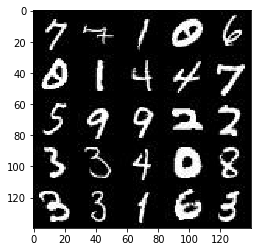

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

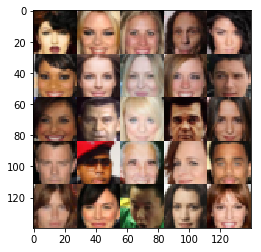

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='z_dim')
    learning_rate = tf.placeholder(tf.float32, None,  name='learning_rate')
    return (input_real, z_data, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        #initial 28x28x3  
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        #14x14x7

        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #7x7x128
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3= tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * x3, x3)
        #4x4x256
        
        #x4 = tf.layers.conv2d(relu3, 1024, 5, strides=2, padding='same')
        #bn4= tf.layers.batch_normalization(x3, training=True)
        #relu4 = tf.maximum(alpha * x4, x4)
        #4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        #output = tf.nn.dropout(output, 0.1)
   
        #print(images.get_shape())
        #print(x1.get_shape())
        #print(x2.get_shape())
        #print(x3.get_shape())
        #print(x4.get_shape())
        #print(logits.get_shape())

        return output,logits 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
        x1 = tf.layers.dense(z, 4*4*512)
        
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, 1, 'same')
        #x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)   
   
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        
        
        output = tf.tanh(logits)
        #output = tf.nn.dropout(output,0.5)
        
        #print(z.get_shape())
        #print(x1.get_shape())
        #print(x2.get_shape())
        #print(x3.get_shape())
        #print(x4.get_shape())
        #print(logits.get_shape())
        
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
import random
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * random.uniform(0.7, 1.2)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*random.uniform(0, 0.3)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    saver = tf.train.Saver()    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                
                _ = sess.run(d_train_opt, feed_dict = {input_real: batch_images, input_z:batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {input_z : batch_z, learn_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {input_z : batch_z, learn_rate:learning_rate})
                
                                

                if steps % 10 == 0:    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriinator Loss: {:.4f}".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriinator Loss: 2.0464 Generator Loss: 0.3967
Epoch 0/2... Discriinator Loss: 1.8461 Generator Loss: 1.9606
Epoch 0/2... Discriinator Loss: 1.0651 Generator Loss: 0.5681
Epoch 0/2... Discriinator Loss: 1.8225 Generator Loss: 0.4005
Epoch 0/2... Discriinator Loss: 1.0558 Generator Loss: 0.7102
Epoch 0/2... Discriinator Loss: 0.8111 Generator Loss: 1.0769
Epoch 0/2... Discriinator Loss: 0.7859 Generator Loss: 1.1781
Epoch 0/2... Discriinator Loss: 2.0846 Generator Loss: 0.4936
Epoch 0/2... Discriinator Loss: 0.8029 Generator Loss: 1.4133
Epoch 0/2... Discriinator Loss: 1.5818 Generator Loss: 0.7514


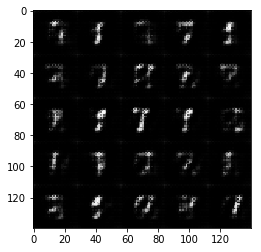

Epoch 0/2... Discriinator Loss: 1.5503 Generator Loss: 0.5841
Epoch 0/2... Discriinator Loss: 1.4277 Generator Loss: 0.7040
Epoch 0/2... Discriinator Loss: 1.2535 Generator Loss: 0.7577
Epoch 0/2... Discriinator Loss: 1.2196 Generator Loss: 0.8107
Epoch 0/2... Discriinator Loss: 1.2106 Generator Loss: 0.9593
Epoch 0/2... Discriinator Loss: 1.2277 Generator Loss: 0.7199
Epoch 0/2... Discriinator Loss: 1.5530 Generator Loss: 0.6309
Epoch 0/2... Discriinator Loss: 1.3716 Generator Loss: 0.5973
Epoch 0/2... Discriinator Loss: 1.3895 Generator Loss: 0.8775
Epoch 0/2... Discriinator Loss: 1.8434 Generator Loss: 0.3261


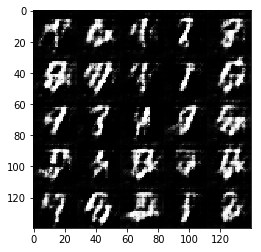

Epoch 0/2... Discriinator Loss: 1.3386 Generator Loss: 0.6822
Epoch 0/2... Discriinator Loss: 1.2741 Generator Loss: 0.9593
Epoch 0/2... Discriinator Loss: 1.3624 Generator Loss: 0.6219
Epoch 0/2... Discriinator Loss: 1.4616 Generator Loss: 0.7384
Epoch 0/2... Discriinator Loss: 1.5832 Generator Loss: 0.7672
Epoch 0/2... Discriinator Loss: 1.5157 Generator Loss: 0.5424
Epoch 0/2... Discriinator Loss: 1.4144 Generator Loss: 0.6965
Epoch 0/2... Discriinator Loss: 1.4736 Generator Loss: 0.7344
Epoch 0/2... Discriinator Loss: 1.4274 Generator Loss: 0.6274
Epoch 0/2... Discriinator Loss: 1.5879 Generator Loss: 0.3544


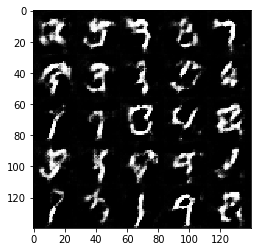

Epoch 0/2... Discriinator Loss: 1.2859 Generator Loss: 0.6576
Epoch 0/2... Discriinator Loss: 1.3194 Generator Loss: 0.8138
Epoch 0/2... Discriinator Loss: 1.2580 Generator Loss: 0.7808
Epoch 0/2... Discriinator Loss: 1.3405 Generator Loss: 0.7012
Epoch 0/2... Discriinator Loss: 1.2831 Generator Loss: 0.7480
Epoch 0/2... Discriinator Loss: 1.2577 Generator Loss: 0.7220
Epoch 0/2... Discriinator Loss: 1.4746 Generator Loss: 0.6233
Epoch 0/2... Discriinator Loss: 1.3810 Generator Loss: 0.5194
Epoch 0/2... Discriinator Loss: 1.3155 Generator Loss: 0.7109
Epoch 0/2... Discriinator Loss: 1.4610 Generator Loss: 0.8813


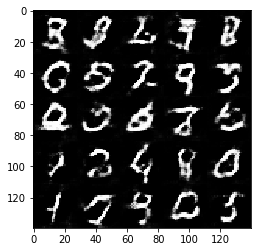

Epoch 0/2... Discriinator Loss: 1.3320 Generator Loss: 0.9509
Epoch 0/2... Discriinator Loss: 1.3684 Generator Loss: 0.6274
Epoch 0/2... Discriinator Loss: 1.3821 Generator Loss: 0.7809
Epoch 0/2... Discriinator Loss: 1.2529 Generator Loss: 1.0124
Epoch 0/2... Discriinator Loss: 1.3412 Generator Loss: 0.9788
Epoch 0/2... Discriinator Loss: 1.3904 Generator Loss: 0.5903
Epoch 0/2... Discriinator Loss: 1.3396 Generator Loss: 0.7235
Epoch 0/2... Discriinator Loss: 1.4604 Generator Loss: 0.4959
Epoch 0/2... Discriinator Loss: 1.3364 Generator Loss: 0.7220
Epoch 0/2... Discriinator Loss: 1.4298 Generator Loss: 0.5763


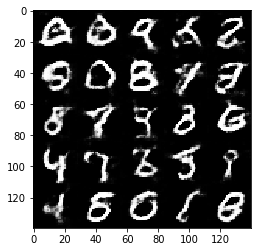

Epoch 0/2... Discriinator Loss: 1.3577 Generator Loss: 0.5621
Epoch 0/2... Discriinator Loss: 1.3655 Generator Loss: 0.9019
Epoch 0/2... Discriinator Loss: 1.3980 Generator Loss: 0.5733
Epoch 0/2... Discriinator Loss: 1.3676 Generator Loss: 0.5052
Epoch 0/2... Discriinator Loss: 1.2630 Generator Loss: 0.9563
Epoch 0/2... Discriinator Loss: 1.5224 Generator Loss: 0.3705
Epoch 0/2... Discriinator Loss: 1.3388 Generator Loss: 0.7544
Epoch 0/2... Discriinator Loss: 1.3919 Generator Loss: 0.5629
Epoch 0/2... Discriinator Loss: 1.4459 Generator Loss: 0.5463
Epoch 0/2... Discriinator Loss: 1.4257 Generator Loss: 0.9134


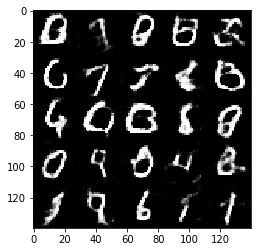

Epoch 0/2... Discriinator Loss: 1.3407 Generator Loss: 0.7007
Epoch 0/2... Discriinator Loss: 1.4052 Generator Loss: 0.7303
Epoch 0/2... Discriinator Loss: 1.4902 Generator Loss: 0.4339
Epoch 0/2... Discriinator Loss: 1.4067 Generator Loss: 0.6341
Epoch 0/2... Discriinator Loss: 1.3520 Generator Loss: 0.8126
Epoch 0/2... Discriinator Loss: 1.4099 Generator Loss: 0.5600
Epoch 0/2... Discriinator Loss: 1.3656 Generator Loss: 0.8960
Epoch 0/2... Discriinator Loss: 1.3009 Generator Loss: 0.6512
Epoch 0/2... Discriinator Loss: 1.4074 Generator Loss: 0.6602
Epoch 0/2... Discriinator Loss: 1.2934 Generator Loss: 1.0958


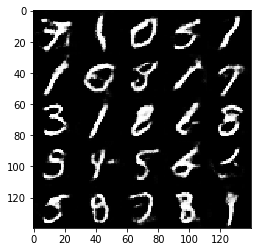

Epoch 0/2... Discriinator Loss: 1.3811 Generator Loss: 0.7132
Epoch 0/2... Discriinator Loss: 1.3626 Generator Loss: 0.8208
Epoch 0/2... Discriinator Loss: 1.3434 Generator Loss: 0.6387
Epoch 0/2... Discriinator Loss: 1.3491 Generator Loss: 0.5604
Epoch 0/2... Discriinator Loss: 1.3645 Generator Loss: 0.6182
Epoch 0/2... Discriinator Loss: 1.4040 Generator Loss: 0.7579
Epoch 0/2... Discriinator Loss: 1.3057 Generator Loss: 1.0042
Epoch 0/2... Discriinator Loss: 1.2395 Generator Loss: 0.7029
Epoch 0/2... Discriinator Loss: 1.3371 Generator Loss: 0.7069
Epoch 0/2... Discriinator Loss: 1.3807 Generator Loss: 0.5412


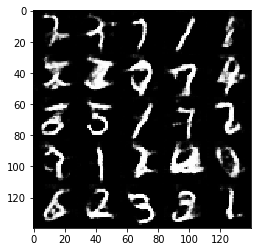

Epoch 0/2... Discriinator Loss: 1.3732 Generator Loss: 0.7369
Epoch 0/2... Discriinator Loss: 1.5133 Generator Loss: 0.4145
Epoch 0/2... Discriinator Loss: 1.3660 Generator Loss: 0.6554
Epoch 0/2... Discriinator Loss: 1.4263 Generator Loss: 0.4857
Epoch 0/2... Discriinator Loss: 1.3287 Generator Loss: 0.8152
Epoch 0/2... Discriinator Loss: 1.5081 Generator Loss: 0.4429
Epoch 0/2... Discriinator Loss: 1.4150 Generator Loss: 0.6692
Epoch 0/2... Discriinator Loss: 1.2665 Generator Loss: 0.6816
Epoch 1/2... Discriinator Loss: 1.3598 Generator Loss: 1.2784
Epoch 1/2... Discriinator Loss: 1.3895 Generator Loss: 0.5266


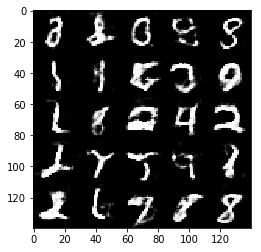

Epoch 1/2... Discriinator Loss: 1.3008 Generator Loss: 0.7515
Epoch 1/2... Discriinator Loss: 1.4404 Generator Loss: 0.4447
Epoch 1/2... Discriinator Loss: 1.3283 Generator Loss: 0.8932
Epoch 1/2... Discriinator Loss: 1.3359 Generator Loss: 0.9998
Epoch 1/2... Discriinator Loss: 1.3420 Generator Loss: 0.5707
Epoch 1/2... Discriinator Loss: 1.4514 Generator Loss: 0.4354
Epoch 1/2... Discriinator Loss: 1.3697 Generator Loss: 0.5444
Epoch 1/2... Discriinator Loss: 1.3882 Generator Loss: 0.7152
Epoch 1/2... Discriinator Loss: 1.2906 Generator Loss: 0.7260
Epoch 1/2... Discriinator Loss: 1.4485 Generator Loss: 0.5485


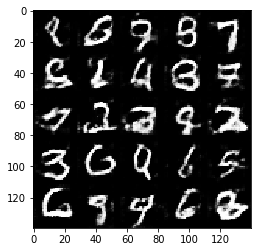

Epoch 1/2... Discriinator Loss: 1.5687 Generator Loss: 0.3613
Epoch 1/2... Discriinator Loss: 1.4573 Generator Loss: 0.6716
Epoch 1/2... Discriinator Loss: 1.3019 Generator Loss: 0.7042
Epoch 1/2... Discriinator Loss: 1.2982 Generator Loss: 0.7059
Epoch 1/2... Discriinator Loss: 1.2785 Generator Loss: 0.5499
Epoch 1/2... Discriinator Loss: 1.4831 Generator Loss: 0.4812
Epoch 1/2... Discriinator Loss: 1.3517 Generator Loss: 0.9260
Epoch 1/2... Discriinator Loss: 1.4746 Generator Loss: 0.4328
Epoch 1/2... Discriinator Loss: 1.2807 Generator Loss: 0.6008
Epoch 1/2... Discriinator Loss: 1.3296 Generator Loss: 0.7629


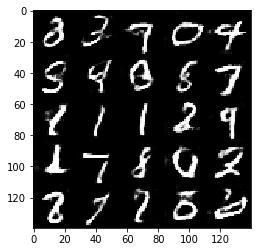

Epoch 1/2... Discriinator Loss: 1.5709 Generator Loss: 0.3721
Epoch 1/2... Discriinator Loss: 1.3143 Generator Loss: 0.7718
Epoch 1/2... Discriinator Loss: 1.3767 Generator Loss: 0.6699
Epoch 1/2... Discriinator Loss: 1.3757 Generator Loss: 0.7343
Epoch 1/2... Discriinator Loss: 1.4424 Generator Loss: 0.4448
Epoch 1/2... Discriinator Loss: 1.3038 Generator Loss: 0.7246
Epoch 1/2... Discriinator Loss: 1.3861 Generator Loss: 0.9660
Epoch 1/2... Discriinator Loss: 1.4449 Generator Loss: 0.6236
Epoch 1/2... Discriinator Loss: 1.4433 Generator Loss: 0.4655
Epoch 1/2... Discriinator Loss: 1.5003 Generator Loss: 1.0002


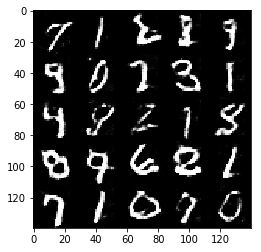

Epoch 1/2... Discriinator Loss: 1.3403 Generator Loss: 0.8541
Epoch 1/2... Discriinator Loss: 1.2734 Generator Loss: 0.7974
Epoch 1/2... Discriinator Loss: 1.5634 Generator Loss: 0.3795
Epoch 1/2... Discriinator Loss: 1.3915 Generator Loss: 0.5949
Epoch 1/2... Discriinator Loss: 1.3138 Generator Loss: 0.7531
Epoch 1/2... Discriinator Loss: 1.3858 Generator Loss: 0.9999
Epoch 1/2... Discriinator Loss: 1.3388 Generator Loss: 0.9351
Epoch 1/2... Discriinator Loss: 1.2991 Generator Loss: 0.5716
Epoch 1/2... Discriinator Loss: 1.9430 Generator Loss: 1.3570
Epoch 1/2... Discriinator Loss: 1.2423 Generator Loss: 0.7388


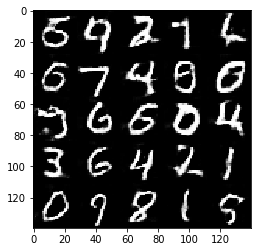

Epoch 1/2... Discriinator Loss: 1.4120 Generator Loss: 0.6350
Epoch 1/2... Discriinator Loss: 1.2912 Generator Loss: 0.7397
Epoch 1/2... Discriinator Loss: 1.7394 Generator Loss: 1.5163
Epoch 1/2... Discriinator Loss: 1.3392 Generator Loss: 0.6655
Epoch 1/2... Discriinator Loss: 1.3911 Generator Loss: 0.5326
Epoch 1/2... Discriinator Loss: 1.2910 Generator Loss: 0.6771
Epoch 1/2... Discriinator Loss: 1.3070 Generator Loss: 0.7015
Epoch 1/2... Discriinator Loss: 1.5993 Generator Loss: 0.3357
Epoch 1/2... Discriinator Loss: 1.3623 Generator Loss: 0.5654
Epoch 1/2... Discriinator Loss: 1.3005 Generator Loss: 0.8266


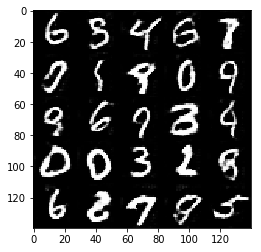

Epoch 1/2... Discriinator Loss: 1.4034 Generator Loss: 0.7144
Epoch 1/2... Discriinator Loss: 1.4161 Generator Loss: 1.1427
Epoch 1/2... Discriinator Loss: 1.2480 Generator Loss: 0.7394
Epoch 1/2... Discriinator Loss: 1.3215 Generator Loss: 0.7579
Epoch 1/2... Discriinator Loss: 1.3899 Generator Loss: 0.4843
Epoch 1/2... Discriinator Loss: 1.5224 Generator Loss: 0.3851
Epoch 1/2... Discriinator Loss: 1.4577 Generator Loss: 0.5389
Epoch 1/2... Discriinator Loss: 1.2979 Generator Loss: 0.5420
Epoch 1/2... Discriinator Loss: 1.4284 Generator Loss: 1.0990
Epoch 1/2... Discriinator Loss: 1.3249 Generator Loss: 1.0559


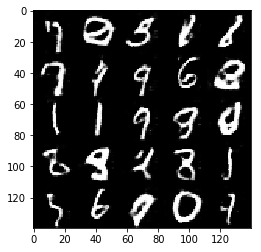

Epoch 1/2... Discriinator Loss: 1.7517 Generator Loss: 0.2732
Epoch 1/2... Discriinator Loss: 1.3414 Generator Loss: 0.6128
Epoch 1/2... Discriinator Loss: 1.2198 Generator Loss: 0.8739
Epoch 1/2... Discriinator Loss: 1.6057 Generator Loss: 0.3156
Epoch 1/2... Discriinator Loss: 1.3616 Generator Loss: 0.7422
Epoch 1/2... Discriinator Loss: 1.3162 Generator Loss: 0.6847
Epoch 1/2... Discriinator Loss: 1.3683 Generator Loss: 0.5746
Epoch 1/2... Discriinator Loss: 1.2403 Generator Loss: 0.7701
Epoch 1/2... Discriinator Loss: 1.2923 Generator Loss: 0.7664
Epoch 1/2... Discriinator Loss: 2.2777 Generator Loss: 1.5366


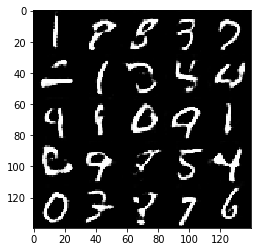

Epoch 1/2... Discriinator Loss: 1.2157 Generator Loss: 0.7798
Epoch 1/2... Discriinator Loss: 1.3344 Generator Loss: 0.6397
Epoch 1/2... Discriinator Loss: 1.4270 Generator Loss: 0.5849
Epoch 1/2... Discriinator Loss: 1.4928 Generator Loss: 0.4845
Epoch 1/2... Discriinator Loss: 1.2512 Generator Loss: 0.8335
Epoch 1/2... Discriinator Loss: 1.3835 Generator Loss: 0.4975
Epoch 1/2... Discriinator Loss: 1.2763 Generator Loss: 0.7812
Epoch 1/2... Discriinator Loss: 1.3688 Generator Loss: 0.4304
Epoch 1/2... Discriinator Loss: 1.2339 Generator Loss: 0.8458
Epoch 1/2... Discriinator Loss: 1.3309 Generator Loss: 0.7210


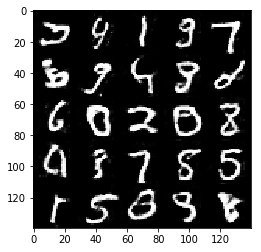

Epoch 1/2... Discriinator Loss: 1.7287 Generator Loss: 0.2922
Epoch 1/2... Discriinator Loss: 1.3786 Generator Loss: 0.7249
Epoch 1/2... Discriinator Loss: 1.2946 Generator Loss: 0.7192
Epoch 1/2... Discriinator Loss: 1.3082 Generator Loss: 0.7693
Epoch 1/2... Discriinator Loss: 1.2544 Generator Loss: 0.8285
Epoch 1/2... Discriinator Loss: 1.3506 Generator Loss: 0.7678
Epoch 1/2... Discriinator Loss: 1.4995 Generator Loss: 1.3944


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriinator Loss: 2.7363 Generator Loss: 0.1707
Epoch 0/1... Discriinator Loss: 3.4316 Generator Loss: 0.1961
Epoch 0/1... Discriinator Loss: 1.8707 Generator Loss: 0.6166
Epoch 0/1... Discriinator Loss: 1.8275 Generator Loss: 0.6701
Epoch 0/1... Discriinator Loss: 2.1719 Generator Loss: 0.4299
Epoch 0/1... Discriinator Loss: 2.0196 Generator Loss: 0.2752
Epoch 0/1... Discriinator Loss: 4.6487 Generator Loss: 0.0193
Epoch 0/1... Discriinator Loss: 1.1219 Generator Loss: 0.4156
Epoch 0/1... Discriinator Loss: 1.8665 Generator Loss: 0.1427
Epoch 0/1... Discriinator Loss: 0.6221 Generator Loss: 1.0445


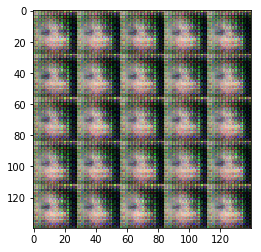

Epoch 0/1... Discriinator Loss: 1.8211 Generator Loss: 0.4633
Epoch 0/1... Discriinator Loss: 0.9232 Generator Loss: 0.5155
Epoch 0/1... Discriinator Loss: 2.1463 Generator Loss: 0.0667
Epoch 0/1... Discriinator Loss: 1.7033 Generator Loss: 0.6799
Epoch 0/1... Discriinator Loss: 3.9405 Generator Loss: 0.1905
Epoch 0/1... Discriinator Loss: 1.4182 Generator Loss: 0.6105
Epoch 0/1... Discriinator Loss: 1.1753 Generator Loss: 0.5537
Epoch 0/1... Discriinator Loss: 0.6560 Generator Loss: 0.7728
Epoch 0/1... Discriinator Loss: 1.8157 Generator Loss: 0.4089
Epoch 0/1... Discriinator Loss: 1.2931 Generator Loss: 0.5536


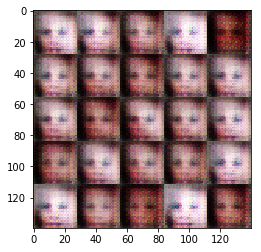

Epoch 0/1... Discriinator Loss: 1.8085 Generator Loss: 0.4517
Epoch 0/1... Discriinator Loss: 0.7641 Generator Loss: 0.6531
Epoch 0/1... Discriinator Loss: 1.3393 Generator Loss: 0.6221
Epoch 0/1... Discriinator Loss: 1.6152 Generator Loss: 0.4716
Epoch 0/1... Discriinator Loss: 1.6306 Generator Loss: 0.4565
Epoch 0/1... Discriinator Loss: 1.1943 Generator Loss: 0.8839
Epoch 0/1... Discriinator Loss: 1.5567 Generator Loss: 0.3686
Epoch 0/1... Discriinator Loss: 1.3969 Generator Loss: 0.5834
Epoch 0/1... Discriinator Loss: 1.8186 Generator Loss: 0.4119
Epoch 0/1... Discriinator Loss: 1.2589 Generator Loss: 0.5219


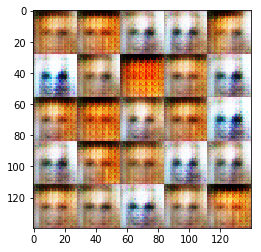

Epoch 0/1... Discriinator Loss: 1.2481 Generator Loss: 0.5843
Epoch 0/1... Discriinator Loss: 1.4649 Generator Loss: 0.5504
Epoch 0/1... Discriinator Loss: 1.4509 Generator Loss: 0.6751
Epoch 0/1... Discriinator Loss: 1.1334 Generator Loss: 0.7370
Epoch 0/1... Discriinator Loss: 1.5074 Generator Loss: 0.6966
Epoch 0/1... Discriinator Loss: 1.5835 Generator Loss: 0.5283
Epoch 0/1... Discriinator Loss: 1.1658 Generator Loss: 0.5974
Epoch 0/1... Discriinator Loss: 1.9203 Generator Loss: 0.4242
Epoch 0/1... Discriinator Loss: 1.3965 Generator Loss: 0.4720
Epoch 0/1... Discriinator Loss: 1.2265 Generator Loss: 0.7610


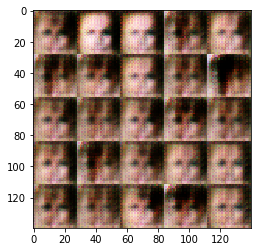

Epoch 0/1... Discriinator Loss: 1.1813 Generator Loss: 0.6150
Epoch 0/1... Discriinator Loss: 1.0839 Generator Loss: 0.5886
Epoch 0/1... Discriinator Loss: 0.8410 Generator Loss: 0.7735
Epoch 0/1... Discriinator Loss: 1.2464 Generator Loss: 0.4596
Epoch 0/1... Discriinator Loss: 1.7802 Generator Loss: 0.4263
Epoch 0/1... Discriinator Loss: 0.9947 Generator Loss: 0.6695
Epoch 0/1... Discriinator Loss: 1.5977 Generator Loss: 0.5174
Epoch 0/1... Discriinator Loss: 1.5939 Generator Loss: 0.5474
Epoch 0/1... Discriinator Loss: 1.2218 Generator Loss: 0.5279
Epoch 0/1... Discriinator Loss: 1.3373 Generator Loss: 0.4776


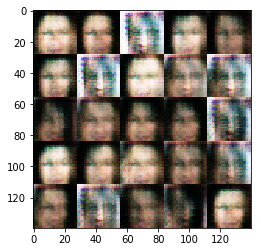

Epoch 0/1... Discriinator Loss: 1.1909 Generator Loss: 0.5877
Epoch 0/1... Discriinator Loss: 1.2786 Generator Loss: 0.6036
Epoch 0/1... Discriinator Loss: 1.3974 Generator Loss: 0.5001
Epoch 0/1... Discriinator Loss: 1.4250 Generator Loss: 0.4865
Epoch 0/1... Discriinator Loss: 1.1583 Generator Loss: 0.5576
Epoch 0/1... Discriinator Loss: 1.8239 Generator Loss: 0.3735
Epoch 0/1... Discriinator Loss: 1.5927 Generator Loss: 0.4325
Epoch 0/1... Discriinator Loss: 1.2149 Generator Loss: 0.4590
Epoch 0/1... Discriinator Loss: 1.3631 Generator Loss: 0.4453
Epoch 0/1... Discriinator Loss: 1.4256 Generator Loss: 0.6196


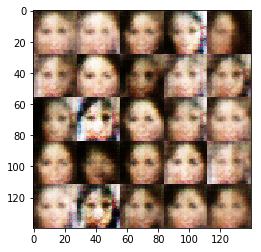

Epoch 0/1... Discriinator Loss: 1.5306 Generator Loss: 0.5499
Epoch 0/1... Discriinator Loss: 1.6448 Generator Loss: 0.4200
Epoch 0/1... Discriinator Loss: 1.4743 Generator Loss: 0.4799
Epoch 0/1... Discriinator Loss: 1.5327 Generator Loss: 0.4001
Epoch 0/1... Discriinator Loss: 1.4822 Generator Loss: 0.6006
Epoch 0/1... Discriinator Loss: 0.9398 Generator Loss: 0.6281
Epoch 0/1... Discriinator Loss: 1.5360 Generator Loss: 0.3670
Epoch 0/1... Discriinator Loss: 1.2290 Generator Loss: 0.5058
Epoch 0/1... Discriinator Loss: 1.2909 Generator Loss: 0.5704
Epoch 0/1... Discriinator Loss: 1.2632 Generator Loss: 0.5489


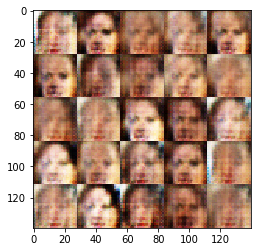

Epoch 0/1... Discriinator Loss: 1.8060 Generator Loss: 0.5607
Epoch 0/1... Discriinator Loss: 1.6604 Generator Loss: 0.4252
Epoch 0/1... Discriinator Loss: 1.6244 Generator Loss: 0.4639
Epoch 0/1... Discriinator Loss: 1.5151 Generator Loss: 0.4845
Epoch 0/1... Discriinator Loss: 1.2458 Generator Loss: 0.5526
Epoch 0/1... Discriinator Loss: 1.4858 Generator Loss: 0.5908
Epoch 0/1... Discriinator Loss: 1.5359 Generator Loss: 0.5601
Epoch 0/1... Discriinator Loss: 1.1975 Generator Loss: 0.5754
Epoch 0/1... Discriinator Loss: 1.3803 Generator Loss: 0.5919
Epoch 0/1... Discriinator Loss: 1.0451 Generator Loss: 0.5863


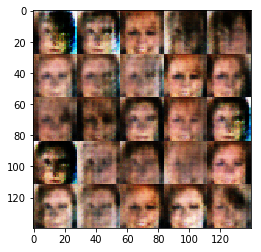

Epoch 0/1... Discriinator Loss: 1.2584 Generator Loss: 0.5382
Epoch 0/1... Discriinator Loss: 1.3831 Generator Loss: 0.3936
Epoch 0/1... Discriinator Loss: 1.2301 Generator Loss: 0.5941
Epoch 0/1... Discriinator Loss: 1.2601 Generator Loss: 0.5338
Epoch 0/1... Discriinator Loss: 1.5216 Generator Loss: 0.5276
Epoch 0/1... Discriinator Loss: 1.4131 Generator Loss: 0.5349
Epoch 0/1... Discriinator Loss: 1.3459 Generator Loss: 0.4797
Epoch 0/1... Discriinator Loss: 1.3338 Generator Loss: 0.4502
Epoch 0/1... Discriinator Loss: 1.3931 Generator Loss: 0.4359
Epoch 0/1... Discriinator Loss: 1.6505 Generator Loss: 0.4481


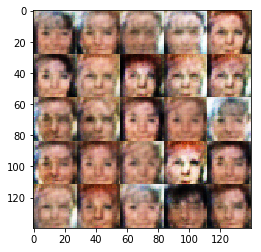

Epoch 0/1... Discriinator Loss: 1.3035 Generator Loss: 0.5344
Epoch 0/1... Discriinator Loss: 1.3640 Generator Loss: 0.4866
Epoch 0/1... Discriinator Loss: 1.7086 Generator Loss: 0.4329
Epoch 0/1... Discriinator Loss: 1.3020 Generator Loss: 0.5970
Epoch 0/1... Discriinator Loss: 1.5233 Generator Loss: 0.5189
Epoch 0/1... Discriinator Loss: 1.3262 Generator Loss: 0.5736
Epoch 0/1... Discriinator Loss: 1.3881 Generator Loss: 0.4746
Epoch 0/1... Discriinator Loss: 1.3721 Generator Loss: 0.5356
Epoch 0/1... Discriinator Loss: 1.2656 Generator Loss: 0.6231
Epoch 0/1... Discriinator Loss: 1.3455 Generator Loss: 0.5277


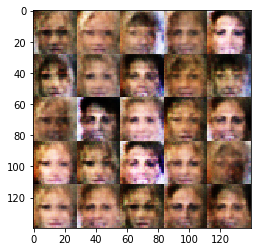

Epoch 0/1... Discriinator Loss: 1.2137 Generator Loss: 0.5336
Epoch 0/1... Discriinator Loss: 1.1158 Generator Loss: 0.5298
Epoch 0/1... Discriinator Loss: 1.5313 Generator Loss: 0.4603
Epoch 0/1... Discriinator Loss: 1.4471 Generator Loss: 0.5229
Epoch 0/1... Discriinator Loss: 1.2691 Generator Loss: 0.6105
Epoch 0/1... Discriinator Loss: 1.3049 Generator Loss: 0.5155
Epoch 0/1... Discriinator Loss: 1.2697 Generator Loss: 0.4840
Epoch 0/1... Discriinator Loss: 1.5783 Generator Loss: 0.4670
Epoch 0/1... Discriinator Loss: 1.7199 Generator Loss: 0.4071
Epoch 0/1... Discriinator Loss: 1.3228 Generator Loss: 0.5325


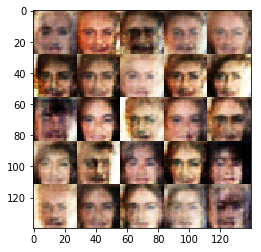

Epoch 0/1... Discriinator Loss: 1.5473 Generator Loss: 0.4973
Epoch 0/1... Discriinator Loss: 1.3121 Generator Loss: 0.5252
Epoch 0/1... Discriinator Loss: 1.3138 Generator Loss: 0.4810
Epoch 0/1... Discriinator Loss: 1.3323 Generator Loss: 0.5216
Epoch 0/1... Discriinator Loss: 1.3467 Generator Loss: 0.5480
Epoch 0/1... Discriinator Loss: 1.5074 Generator Loss: 0.4215
Epoch 0/1... Discriinator Loss: 1.3249 Generator Loss: 0.5004
Epoch 0/1... Discriinator Loss: 1.3436 Generator Loss: 0.4862
Epoch 0/1... Discriinator Loss: 1.2283 Generator Loss: 0.5482
Epoch 0/1... Discriinator Loss: 1.3891 Generator Loss: 0.5142


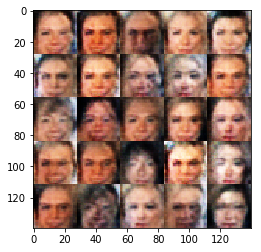

Epoch 0/1... Discriinator Loss: 1.5102 Generator Loss: 0.4445
Epoch 0/1... Discriinator Loss: 1.3933 Generator Loss: 0.5049
Epoch 0/1... Discriinator Loss: 1.4670 Generator Loss: 0.4683
Epoch 0/1... Discriinator Loss: 1.5275 Generator Loss: 0.4990
Epoch 0/1... Discriinator Loss: 1.6164 Generator Loss: 0.4426
Epoch 0/1... Discriinator Loss: 1.3528 Generator Loss: 0.5031
Epoch 0/1... Discriinator Loss: 1.3535 Generator Loss: 0.4948
Epoch 0/1... Discriinator Loss: 1.2351 Generator Loss: 0.5480
Epoch 0/1... Discriinator Loss: 1.5065 Generator Loss: 0.4427
Epoch 0/1... Discriinator Loss: 1.3383 Generator Loss: 0.5192


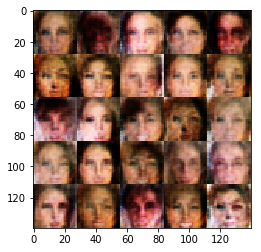

Epoch 0/1... Discriinator Loss: 1.4819 Generator Loss: 0.5440
Epoch 0/1... Discriinator Loss: 1.5076 Generator Loss: 0.4699
Epoch 0/1... Discriinator Loss: 1.3690 Generator Loss: 0.4804
Epoch 0/1... Discriinator Loss: 1.5184 Generator Loss: 0.5502
Epoch 0/1... Discriinator Loss: 1.3493 Generator Loss: 0.5423
Epoch 0/1... Discriinator Loss: 1.3178 Generator Loss: 0.5186
Epoch 0/1... Discriinator Loss: 1.2108 Generator Loss: 0.5167
Epoch 0/1... Discriinator Loss: 1.5553 Generator Loss: 0.4551
Epoch 0/1... Discriinator Loss: 1.4498 Generator Loss: 0.4393
Epoch 0/1... Discriinator Loss: 1.5575 Generator Loss: 0.4191


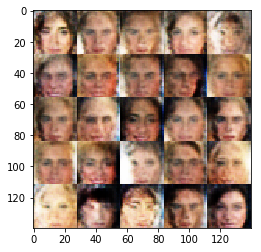

Epoch 0/1... Discriinator Loss: 1.3365 Generator Loss: 0.5467
Epoch 0/1... Discriinator Loss: 1.3948 Generator Loss: 0.4770
Epoch 0/1... Discriinator Loss: 1.4085 Generator Loss: 0.5037
Epoch 0/1... Discriinator Loss: 1.2752 Generator Loss: 0.5101
Epoch 0/1... Discriinator Loss: 1.3633 Generator Loss: 0.4884
Epoch 0/1... Discriinator Loss: 1.3589 Generator Loss: 0.4982
Epoch 0/1... Discriinator Loss: 1.4020 Generator Loss: 0.5076
Epoch 0/1... Discriinator Loss: 1.4849 Generator Loss: 0.4561
Epoch 0/1... Discriinator Loss: 1.4893 Generator Loss: 0.5194
Epoch 0/1... Discriinator Loss: 1.4888 Generator Loss: 0.4612


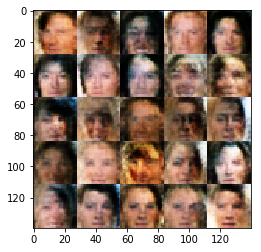

Epoch 0/1... Discriinator Loss: 1.4283 Generator Loss: 0.4641
Epoch 0/1... Discriinator Loss: 1.4103 Generator Loss: 0.5130
Epoch 0/1... Discriinator Loss: 1.5231 Generator Loss: 0.4769
Epoch 0/1... Discriinator Loss: 1.3774 Generator Loss: 0.4605
Epoch 0/1... Discriinator Loss: 1.5334 Generator Loss: 0.4791
Epoch 0/1... Discriinator Loss: 1.4507 Generator Loss: 0.4899
Epoch 0/1... Discriinator Loss: 1.3146 Generator Loss: 0.4951
Epoch 0/1... Discriinator Loss: 1.3216 Generator Loss: 0.5034
Epoch 0/1... Discriinator Loss: 1.3636 Generator Loss: 0.5313
Epoch 0/1... Discriinator Loss: 1.3592 Generator Loss: 0.5014


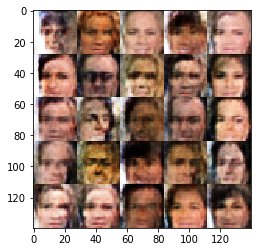

Epoch 0/1... Discriinator Loss: 1.5035 Generator Loss: 0.5043
Epoch 0/1... Discriinator Loss: 1.2456 Generator Loss: 0.5246
Epoch 0/1... Discriinator Loss: 1.5210 Generator Loss: 0.4618
Epoch 0/1... Discriinator Loss: 1.5533 Generator Loss: 0.4539
Epoch 0/1... Discriinator Loss: 1.4534 Generator Loss: 0.4636
Epoch 0/1... Discriinator Loss: 1.4705 Generator Loss: 0.4456
Epoch 0/1... Discriinator Loss: 1.3462 Generator Loss: 0.4842
Epoch 0/1... Discriinator Loss: 1.2614 Generator Loss: 0.5347
Epoch 0/1... Discriinator Loss: 1.3223 Generator Loss: 0.5118
Epoch 0/1... Discriinator Loss: 1.4291 Generator Loss: 0.5358


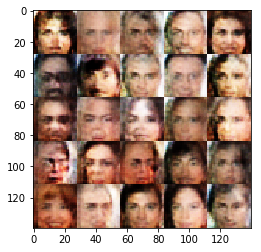

Epoch 0/1... Discriinator Loss: 1.2842 Generator Loss: 0.4851
Epoch 0/1... Discriinator Loss: 1.3303 Generator Loss: 0.5193
Epoch 0/1... Discriinator Loss: 1.4586 Generator Loss: 0.4282
Epoch 0/1... Discriinator Loss: 1.3677 Generator Loss: 0.5002
Epoch 0/1... Discriinator Loss: 1.3974 Generator Loss: 0.5217
Epoch 0/1... Discriinator Loss: 1.3826 Generator Loss: 0.5002
Epoch 0/1... Discriinator Loss: 1.3996 Generator Loss: 0.5417
Epoch 0/1... Discriinator Loss: 1.3338 Generator Loss: 0.5061
Epoch 0/1... Discriinator Loss: 1.4501 Generator Loss: 0.4548
Epoch 0/1... Discriinator Loss: 1.2135 Generator Loss: 0.5171


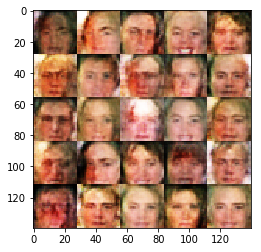

Epoch 0/1... Discriinator Loss: 1.5661 Generator Loss: 0.4665
Epoch 0/1... Discriinator Loss: 1.4342 Generator Loss: 0.4754
Epoch 0/1... Discriinator Loss: 1.4058 Generator Loss: 0.4967
Epoch 0/1... Discriinator Loss: 1.2994 Generator Loss: 0.4939
Epoch 0/1... Discriinator Loss: 1.4663 Generator Loss: 0.4757
Epoch 0/1... Discriinator Loss: 1.3990 Generator Loss: 0.4905
Epoch 0/1... Discriinator Loss: 1.3744 Generator Loss: 0.4487
Epoch 0/1... Discriinator Loss: 1.1951 Generator Loss: 0.5807
Epoch 0/1... Discriinator Loss: 1.3651 Generator Loss: 0.5256
Epoch 0/1... Discriinator Loss: 1.4701 Generator Loss: 0.4725


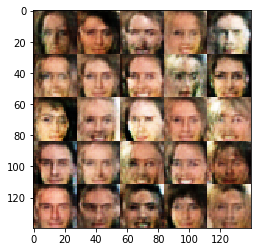

Epoch 0/1... Discriinator Loss: 1.3317 Generator Loss: 0.4877
Epoch 0/1... Discriinator Loss: 1.3739 Generator Loss: 0.4988
Epoch 0/1... Discriinator Loss: 1.4399 Generator Loss: 0.4920
Epoch 0/1... Discriinator Loss: 1.3675 Generator Loss: 0.4173
Epoch 0/1... Discriinator Loss: 1.4622 Generator Loss: 0.4711
Epoch 0/1... Discriinator Loss: 1.3864 Generator Loss: 0.5097
Epoch 0/1... Discriinator Loss: 1.4363 Generator Loss: 0.4502
Epoch 0/1... Discriinator Loss: 1.3364 Generator Loss: 0.4659
Epoch 0/1... Discriinator Loss: 1.4012 Generator Loss: 0.4940
Epoch 0/1... Discriinator Loss: 1.4588 Generator Loss: 0.4719


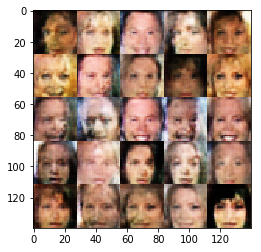

Epoch 0/1... Discriinator Loss: 1.4498 Generator Loss: 0.5028
Epoch 0/1... Discriinator Loss: 1.4106 Generator Loss: 0.4910
Epoch 0/1... Discriinator Loss: 1.4172 Generator Loss: 0.5053
Epoch 0/1... Discriinator Loss: 1.4236 Generator Loss: 0.4865
Epoch 0/1... Discriinator Loss: 1.3319 Generator Loss: 0.4925
Epoch 0/1... Discriinator Loss: 1.3514 Generator Loss: 0.5543
Epoch 0/1... Discriinator Loss: 1.3441 Generator Loss: 0.5060
Epoch 0/1... Discriinator Loss: 1.4315 Generator Loss: 0.5098
Epoch 0/1... Discriinator Loss: 1.4812 Generator Loss: 0.4795
Epoch 0/1... Discriinator Loss: 1.3418 Generator Loss: 0.4502


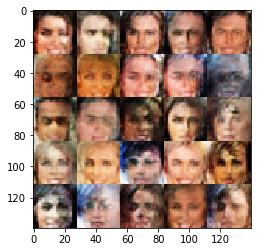

Epoch 0/1... Discriinator Loss: 1.4192 Generator Loss: 0.5067
Epoch 0/1... Discriinator Loss: 1.5015 Generator Loss: 0.4720
Epoch 0/1... Discriinator Loss: 1.2957 Generator Loss: 0.5078
Epoch 0/1... Discriinator Loss: 1.4843 Generator Loss: 0.4534
Epoch 0/1... Discriinator Loss: 1.4292 Generator Loss: 0.4760
Epoch 0/1... Discriinator Loss: 1.4093 Generator Loss: 0.4657
Epoch 0/1... Discriinator Loss: 1.3549 Generator Loss: 0.5042
Epoch 0/1... Discriinator Loss: 1.3979 Generator Loss: 0.4539
Epoch 0/1... Discriinator Loss: 1.3106 Generator Loss: 0.5001
Epoch 0/1... Discriinator Loss: 1.4695 Generator Loss: 0.4774


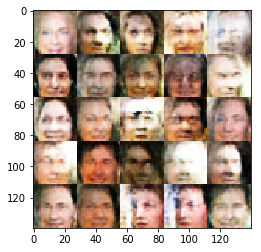

Epoch 0/1... Discriinator Loss: 1.6762 Generator Loss: 0.4487
Epoch 0/1... Discriinator Loss: 1.4656 Generator Loss: 0.4775
Epoch 0/1... Discriinator Loss: 1.5128 Generator Loss: 0.4446
Epoch 0/1... Discriinator Loss: 1.5094 Generator Loss: 0.4415
Epoch 0/1... Discriinator Loss: 1.3660 Generator Loss: 0.4257
Epoch 0/1... Discriinator Loss: 1.4159 Generator Loss: 0.5132
Epoch 0/1... Discriinator Loss: 1.4341 Generator Loss: 0.4830
Epoch 0/1... Discriinator Loss: 1.5196 Generator Loss: 0.4031
Epoch 0/1... Discriinator Loss: 1.3926 Generator Loss: 0.5103
Epoch 0/1... Discriinator Loss: 1.3734 Generator Loss: 0.5027


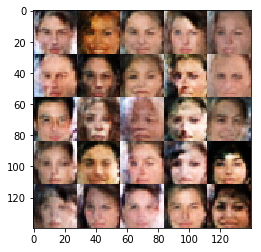

Epoch 0/1... Discriinator Loss: 1.3928 Generator Loss: 0.4409
Epoch 0/1... Discriinator Loss: 1.3038 Generator Loss: 0.5010
Epoch 0/1... Discriinator Loss: 1.5025 Generator Loss: 0.4529
Epoch 0/1... Discriinator Loss: 1.4109 Generator Loss: 0.4789
Epoch 0/1... Discriinator Loss: 1.3594 Generator Loss: 0.4664
Epoch 0/1... Discriinator Loss: 1.5314 Generator Loss: 0.4415
Epoch 0/1... Discriinator Loss: 1.3816 Generator Loss: 0.4369
Epoch 0/1... Discriinator Loss: 1.3744 Generator Loss: 0.4849
Epoch 0/1... Discriinator Loss: 1.3539 Generator Loss: 0.4760
Epoch 0/1... Discriinator Loss: 1.4895 Generator Loss: 0.5011


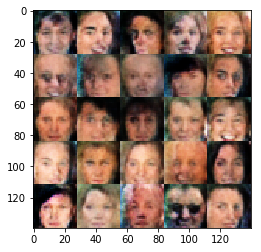

Epoch 0/1... Discriinator Loss: 1.3756 Generator Loss: 0.4723
Epoch 0/1... Discriinator Loss: 1.3334 Generator Loss: 0.4640
Epoch 0/1... Discriinator Loss: 1.3761 Generator Loss: 0.5133
Epoch 0/1... Discriinator Loss: 1.3942 Generator Loss: 0.4879
Epoch 0/1... Discriinator Loss: 1.4006 Generator Loss: 0.4724
Epoch 0/1... Discriinator Loss: 1.3691 Generator Loss: 0.4876
Epoch 0/1... Discriinator Loss: 1.4637 Generator Loss: 0.4639
Epoch 0/1... Discriinator Loss: 1.4220 Generator Loss: 0.4693
Epoch 0/1... Discriinator Loss: 1.4668 Generator Loss: 0.4678
Epoch 0/1... Discriinator Loss: 1.4683 Generator Loss: 0.4732


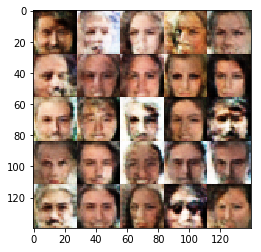

Epoch 0/1... Discriinator Loss: 1.3862 Generator Loss: 0.5432
Epoch 0/1... Discriinator Loss: 1.4331 Generator Loss: 0.4636
Epoch 0/1... Discriinator Loss: 1.4566 Generator Loss: 0.5356
Epoch 0/1... Discriinator Loss: 1.4935 Generator Loss: 0.4552
Epoch 0/1... Discriinator Loss: 1.3706 Generator Loss: 0.4746
Epoch 0/1... Discriinator Loss: 1.5276 Generator Loss: 0.4748
Epoch 0/1... Discriinator Loss: 1.4340 Generator Loss: 0.4776
Epoch 0/1... Discriinator Loss: 1.3487 Generator Loss: 0.4843
Epoch 0/1... Discriinator Loss: 1.4403 Generator Loss: 0.5213
Epoch 0/1... Discriinator Loss: 1.3106 Generator Loss: 0.5091


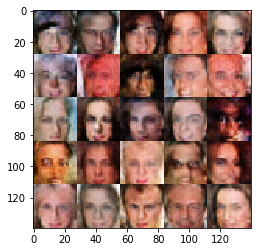

Epoch 0/1... Discriinator Loss: 1.3825 Generator Loss: 0.5118
Epoch 0/1... Discriinator Loss: 1.4355 Generator Loss: 0.4826
Epoch 0/1... Discriinator Loss: 1.4669 Generator Loss: 0.4581
Epoch 0/1... Discriinator Loss: 1.3486 Generator Loss: 0.5113
Epoch 0/1... Discriinator Loss: 1.5700 Generator Loss: 0.4672
Epoch 0/1... Discriinator Loss: 1.4048 Generator Loss: 0.4989
Epoch 0/1... Discriinator Loss: 1.3675 Generator Loss: 0.4745
Epoch 0/1... Discriinator Loss: 1.4235 Generator Loss: 0.4543
Epoch 0/1... Discriinator Loss: 1.3484 Generator Loss: 0.5034
Epoch 0/1... Discriinator Loss: 1.4234 Generator Loss: 0.4700


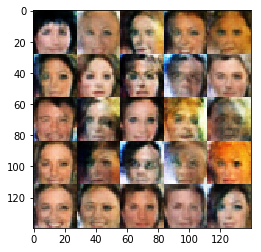

Epoch 0/1... Discriinator Loss: 1.4950 Generator Loss: 0.4768
Epoch 0/1... Discriinator Loss: 1.4048 Generator Loss: 0.5172
Epoch 0/1... Discriinator Loss: 1.4230 Generator Loss: 0.5134
Epoch 0/1... Discriinator Loss: 1.3946 Generator Loss: 0.4360
Epoch 0/1... Discriinator Loss: 1.4467 Generator Loss: 0.4348
Epoch 0/1... Discriinator Loss: 1.4424 Generator Loss: 0.4647
Epoch 0/1... Discriinator Loss: 1.4004 Generator Loss: 0.4768
Epoch 0/1... Discriinator Loss: 1.4256 Generator Loss: 0.4386
Epoch 0/1... Discriinator Loss: 1.3504 Generator Loss: 0.4764
Epoch 0/1... Discriinator Loss: 1.4838 Generator Loss: 0.5292


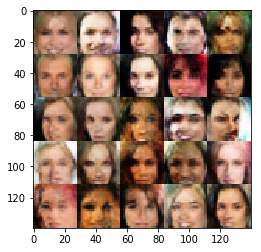

Epoch 0/1... Discriinator Loss: 1.3856 Generator Loss: 0.4829
Epoch 0/1... Discriinator Loss: 1.4377 Generator Loss: 0.4290
Epoch 0/1... Discriinator Loss: 1.3447 Generator Loss: 0.5146
Epoch 0/1... Discriinator Loss: 1.4000 Generator Loss: 0.4459
Epoch 0/1... Discriinator Loss: 1.4017 Generator Loss: 0.4843
Epoch 0/1... Discriinator Loss: 1.4209 Generator Loss: 0.4750
Epoch 0/1... Discriinator Loss: 1.3982 Generator Loss: 0.4757
Epoch 0/1... Discriinator Loss: 1.3298 Generator Loss: 0.5370
Epoch 0/1... Discriinator Loss: 1.4257 Generator Loss: 0.5102
Epoch 0/1... Discriinator Loss: 1.4308 Generator Loss: 0.4739


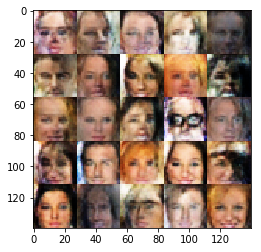

Epoch 0/1... Discriinator Loss: 1.4144 Generator Loss: 0.5221
Epoch 0/1... Discriinator Loss: 1.4021 Generator Loss: 0.4882
Epoch 0/1... Discriinator Loss: 1.4336 Generator Loss: 0.4668
Epoch 0/1... Discriinator Loss: 1.4520 Generator Loss: 0.4973
Epoch 0/1... Discriinator Loss: 1.4177 Generator Loss: 0.5007
Epoch 0/1... Discriinator Loss: 1.3974 Generator Loss: 0.4712
Epoch 0/1... Discriinator Loss: 1.3879 Generator Loss: 0.4391
Epoch 0/1... Discriinator Loss: 1.4325 Generator Loss: 0.5101
Epoch 0/1... Discriinator Loss: 1.4248 Generator Loss: 0.4693
Epoch 0/1... Discriinator Loss: 1.3122 Generator Loss: 0.4714


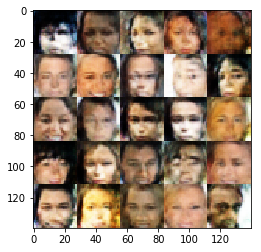

Epoch 0/1... Discriinator Loss: 1.4371 Generator Loss: 0.4913
Epoch 0/1... Discriinator Loss: 1.4189 Generator Loss: 0.5000
Epoch 0/1... Discriinator Loss: 1.3483 Generator Loss: 0.4944
Epoch 0/1... Discriinator Loss: 1.4408 Generator Loss: 0.4609
Epoch 0/1... Discriinator Loss: 1.4660 Generator Loss: 0.4757
Epoch 0/1... Discriinator Loss: 1.3901 Generator Loss: 0.4799
Epoch 0/1... Discriinator Loss: 1.3160 Generator Loss: 0.4581
Epoch 0/1... Discriinator Loss: 1.4325 Generator Loss: 0.5140
Epoch 0/1... Discriinator Loss: 1.4150 Generator Loss: 0.4464
Epoch 0/1... Discriinator Loss: 1.4230 Generator Loss: 0.4943


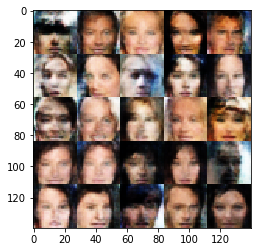

Epoch 0/1... Discriinator Loss: 1.3680 Generator Loss: 0.4048
Epoch 0/1... Discriinator Loss: 1.3956 Generator Loss: 0.4860
Epoch 0/1... Discriinator Loss: 1.4139 Generator Loss: 0.5194
Epoch 0/1... Discriinator Loss: 1.4425 Generator Loss: 0.4621
Epoch 0/1... Discriinator Loss: 1.3980 Generator Loss: 0.4866
Epoch 0/1... Discriinator Loss: 1.3628 Generator Loss: 0.5023


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.